# Lab 4 - Comparing Classification Models



---















In [67]:
import keras
import numpy as np
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews.

In [68]:
imdb = keras.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

We now can start playing around with the data, let’s first see the length:

In [69]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [70]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [71]:
word_index = imdb.get_word_index()

Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [72]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [73]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [74]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [75]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [76]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

In [77]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))



### Preparing input data

In [78]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [79]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

In [80]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


# Model 1: Neural averaging network using one-hot vectors

In [81]:
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

Input = Input((256,), dtype='int32')
Lambda = Lambda(OneHot(VOCAB_SIZE,MAX_SEQUENCE_LENGTH))(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Lambda)
Hidden_1 = Dense(16)(global_average_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model = Model(inputs=[Input], outputs=[Output])  

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 10000)        0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 10000)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Model: "Model_1_One_Hot_Encoding"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# Input (InputLayer)           [(None, 256)]             0         
# _________________________________________________________________
# lambda (Lambda)              (None, 256, 10000)        0         
# _________________________________________________________________
# global_average_pooling1d_mas (None, 10000)             0         
# _________________________________________________________________
# Hidden_1 (Dense)             (None, 16)                160016    
# _________________________________________________________________
# Output (Dense)               (None, 1)                 17        
# =================================================================
# Total params: 160,033
# Trainable params: 160,033
# Non-trainable params: 0

### Training the model

In [83]:
# your code goes here
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [84]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [85]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 68s 2s/step - loss: 0.6928 - accuracy: 0.5102 - val_loss: 0.6914 - val_accuracy: 0.4969
Epoch 2/40
30/30 [==============================] - 65s 2s/step - loss: 0.6903 - accuracy: 0.5967 - val_loss: 0.6886 - val_accuracy: 0.6560
Epoch 3/40
30/30 [==============================] - 72s 2s/step - loss: 0.6876 - accuracy: 0.6604 - val_loss: 0.6855 - val_accuracy: 0.6582
Epoch 4/40
30/30 [==============================] - 72s 2s/step - loss: 0.6837 - accuracy: 0.6450 - val_loss: 0.6814 - val_accuracy: 0.6677
Epoch 5/40
30/30 [==============================] - 72s 2s/step - loss: 0.6800 - accuracy: 0.6466 - val_loss: 0.6775 - val_accuracy: 0.6542
Epoch 6/40
30/30 [==============================] - 72s 2s/step - loss: 0.6751 - accuracy: 0.6527 - val_loss: 0.6722 - val_accuracy: 0.6734
Epoch 7/40
30/30 [==============================] - 71s 2s/step - loss: 0.6696 - accuracy: 0.6806 - val_loss: 0.6675 - val_accuracy: 0.6688
Epoch 8/40
30/30 [==

### Evaluating the model

To evaulate the model on test data:

In [86]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 66s 84ms/step - loss: 0.5339 - accuracy: 0.74270s - loss: 0.534


In [87]:
print(results)
# loss, accuracay 

[0.5338621735572815, 0.742680013179779]


### Plotting the accuracy graph

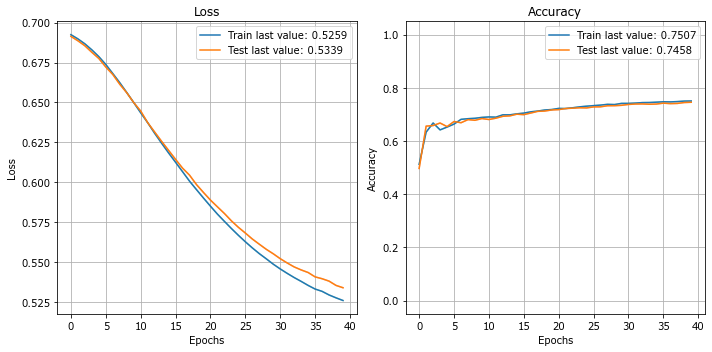

In [88]:
# your code goes here

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Neural averaging network using embedding layer

In [89]:
# your code goes here

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256
EMBED_SIZE = 100

Input = Input((256,), dtype='int32')
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH, mask_zero=True)(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model2 = Model(inputs=[Input], outputs=[Output])  

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model2.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 256, 100)          1000000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


In [90]:
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 3s 70ms/step - loss: 0.7671 - accuracy: 0.4950 - val_loss: 0.7098 - val_accuracy: 0.5053
Epoch 2/40
30/30 [==============================] - 2s 64ms/step - loss: 0.7007 - accuracy: 0.5033 - val_loss: 0.6818 - val_accuracy: 0.7440
Epoch 3/40
30/30 [==============================] - 2s 66ms/step - loss: 0.6770 - accuracy: 0.6946 - val_loss: 0.6669 - val_accuracy: 0.7040
Epoch 4/40
30/30 [==============================] - 2s 65ms/step - loss: 0.6574 - accuracy: 0.7631 - val_loss: 0.6413 - val_accuracy: 0.7832
Epoch 5/40
30/30 [==============================] - 2s 63ms/step - loss: 0.6272 - accuracy: 0.8045 - val_loss: 0.6045 - val_accuracy: 0.7953
Epoch 6/40
30/30 [==============================] - 2s 62ms/step - loss: 0.5853 - accuracy: 0.8144 - val_loss: 0.5591 - val_accuracy: 0.8063
Epoch 7/40
30/30 [==============================] - 2s 64ms/step - loss: 0.5367 - accuracy: 0.8262 - val_loss: 0.5120 - val_accuracy: 0.8214
Epoch 8/40
30

In [91]:
results = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.8675


In [92]:
print (results)

[0.3467300534248352, 0.8674799799919128]


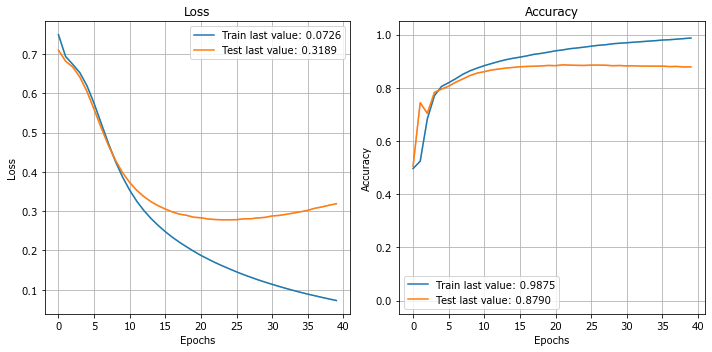

In [93]:
#Plot

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

In [94]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r',encoding="utf8") as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [95]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [96]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


We freeze the weights. To create the model: 

In [97]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)



Size of Embedding:  300


In [98]:
from keras.layers import Embedding

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)


## Model 3-1: Neural bag of words using pre-trained word embeddings

In [99]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

Input = Input(shape=(None,), dtype="int32")
Embedding = embeddingLayer(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model3 = Model(inputs=[Input], outputs=[Output])  

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model3.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


In [100]:
# Train and test the model

history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/40
30/30 [==============================] - 3s 70ms/step - loss: 1.1761 - accuracy: 0.4967 - val_loss: 0.8884 - val_accuracy: 0.5053
Epoch 2/40
30/30 [==============================] - 2s 63ms/step - loss: 0.8591 - accuracy: 0.4926 - val_loss: 0.7590 - val_accuracy: 0.5053
Epoch 3/40
30/30 [==============================] - 2s 65ms/step - loss: 0.7528 - accuracy: 0.4947 - val_loss: 0.7243 - val_accuracy: 0.5056
Epoch 4/40
30/30 [==============================] - 2s 65ms/step - loss: 0.7216 - accuracy: 0.4959 - val_loss: 0.7127 - val_accuracy: 0.5017
Epoch 5/40
30/30 [==============================] - 2s 63ms/step - loss: 0.7126 - accuracy: 0.4963 - val_loss: 0.7083 - val_accuracy: 0.4972
Epoch 6/40
30/30 [==============================] - 2s 63ms/step - loss: 0.7087 - accuracy: 0.4997 - val_loss: 0.7062 - val_accuracy: 0.5004
Epoch 7/40
30/30 [==============================] - 2s 62ms/step - loss: 0.7053 - accuracy: 0.5051 - val_loss: 0.7051 - val_accuracy: 0.5033
Epoch 8/40
30

In [101]:
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.6741 - accuracy: 0.5905


In [102]:
print (results)

[0.6740505695343018, 0.5904800295829773]


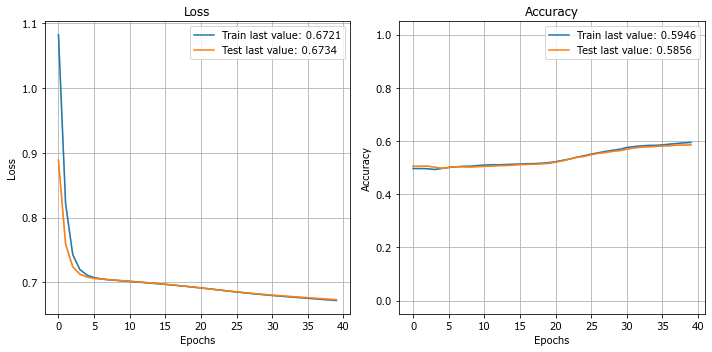

In [103]:
#Plot

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

In [104]:
# your code goes here

from keras.layers import Embedding

embeddingLayer1=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)



In [105]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

Input = Input(shape=(None,), dtype="int32")
Embedding = embeddingLayer1(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model4 = Model(inputs=[Input], outputs=[Output])  

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model4.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_6 ( (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 120,005,133
Trainable params: 120,005,133
Non-trainable params: 0
_________________________________________________________________


In [106]:
# Train and test the model
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 32s 1s/step - loss: 0.7208 - accuracy: 0.5091 - val_loss: 0.6935 - val_accuracy: 0.5106
Epoch 2/40
30/30 [==============================] - 31s 1s/step - loss: 0.6896 - accuracy: 0.5305 - val_loss: 0.6849 - val_accuracy: 0.5731
Epoch 3/40
30/30 [==============================] - 31s 1s/step - loss: 0.6808 - accuracy: 0.6059 - val_loss: 0.6721 - val_accuracy: 0.6779
Epoch 4/40
30/30 [==============================] - 31s 1s/step - loss: 0.6658 - accuracy: 0.6924 - val_loss: 0.6542 - val_accuracy: 0.6962
Epoch 5/40
30/30 [==============================] - 30s 1s/step - loss: 0.6441 - accuracy: 0.7098 - val_loss: 0.6279 - val_accuracy: 0.7222
Epoch 6/40
30/30 [==============================] - 30s 1s/step - loss: 0.6126 - accuracy: 0.7376 - val_loss: 0.5925 - val_accuracy: 0.7466
Epoch 7/40
30/30 [==============================] - 30s 1s/step - loss: 0.5704 - accuracy: 0.7597 - val_loss: 0.5489 - val_accuracy: 0.7766
Epoch 8/40
30/30 [==

In [107]:
results = model4.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.3600 - accuracy: 0.8683


In [108]:
print (results)

[0.35995733737945557, 0.8682799935340881]


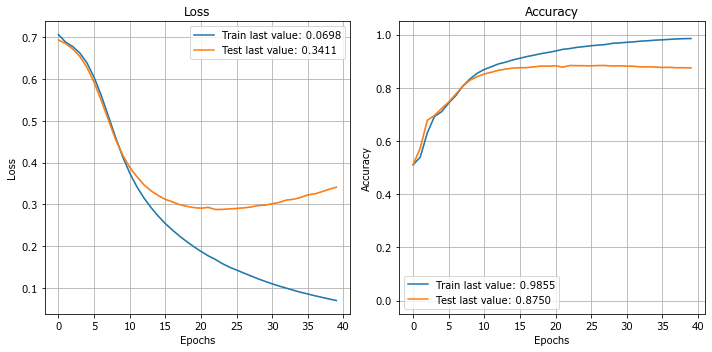

In [109]:
#Plot

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

##  Model 3-2: LSTM with pre-trained word embeddings

In [12]:
from keras.layers import Embedding

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)


In [13]:
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model
from keras.models import Sequential

EMBED_SIZE = 100

#Diff style

Input = Input(shape=(256,), dtype="int32")
Embedding = embeddingLayer(Input)
LSTM = LSTM(100, return_sequences=False)(Embedding)
DenseOutput = Dense(1, activation='softmax')(LSTM)
model5 = Model(inputs=[Input], outputs=[DenseOutput])  
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 120,160,801
Trainable params: 120,160,801
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Train and test the model

history = model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 61s 2s/step - loss: 0.6695 - accuracy: 0.4965 - val_loss: 0.6711 - val_accuracy: 0.5053
Epoch 2/40
30/30 [==============================] - 61s 2s/step - loss: 0.6423 - accuracy: 0.4965 - val_loss: 0.6231 - val_accuracy: 0.5053
Epoch 3/40
30/30 [==============================] - 61s 2s/step - loss: 0.6504 - accuracy: 0.4965 - val_loss: 0.6753 - val_accuracy: 0.5053
Epoch 4/40
30/30 [==============================] - 62s 2s/step - loss: 0.6465 - accuracy: 0.4965 - val_loss: 0.6607 - val_accuracy: 0.5053
Epoch 5/40
30/30 [==============================] - 62s 2s/step - loss: 0.6356 - accuracy: 0.4965 - val_loss: 0.6771 - val_accuracy: 0.5053
Epoch 6/40
30/30 [==============================] - 66s 2s/step - loss: 0.6199 - accuracy: 0.4965 - val_loss: 0.6533 - val_accuracy: 0.5053
Epoch 7/40
30/30 [==============================] - 68s 2s/step - loss: 0.5333 - accuracy: 0.4965 - val_loss: 0.5522 - val_accuracy: 0.5053
Epoch 8/40
30/30 [==

In [34]:
results = model5.evaluate(X_test_enc, y_test)

782/782 [==============================] - 27s 34ms/step - loss: 0.5091 - accuracy: 0.5000


In [35]:
print (results)

[0.5090847015380859, 0.5]


#  Model 4: Adding extra dense layer into Neural averaging network model

### Adding one extra dense layer

In [117]:
from keras.layers import Embedding

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

In [119]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

Input = Input(shape=(None,), dtype="int32")
Embedding = embeddingLayer(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Hidden_2 = Dense(8,activation='sigmoid')(Hidden_1)                     # first extra hidden layer
Output = Dense(1, activation='sigmoid')(Hidden_2)
model6 = Model(inputs=[Input], outputs=[Output])  

model6.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model6.summary()


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_10  (None, 300)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_39 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 9         
Total params: 120,005,261
Trainable params: 4,961
Non-trainable params: 120,000,300
________________________________________

In [120]:
#Train model
history = model6.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
#Test model
results = model6.evaluate(X_test_enc, y_test)
print (results)

Epoch 1/40
30/30 [==============================] - 3s 75ms/step - loss: 0.6939 - accuracy: 0.5088 - val_loss: 0.6925 - val_accuracy: 0.5070
Epoch 2/40
30/30 [==============================] - 2s 68ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6915 - val_accuracy: 0.5468
Epoch 3/40
30/30 [==============================] - 2s 68ms/step - loss: 0.6910 - accuracy: 0.5489 - val_loss: 0.6906 - val_accuracy: 0.5312
Epoch 4/40
30/30 [==============================] - 2s 68ms/step - loss: 0.6898 - accuracy: 0.5409 - val_loss: 0.6889 - val_accuracy: 0.5795
Epoch 5/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6882 - accuracy: 0.5716 - val_loss: 0.6876 - val_accuracy: 0.5715
Epoch 6/40
30/30 [==============================] - 2s 70ms/step - loss: 0.6866 - accuracy: 0.5829 - val_loss: 0.6858 - val_accuracy: 0.5825
Epoch 7/40
30/30 [==============================] - 2s 73ms/step - loss: 0.6842 - accuracy: 0.5975 - val_loss: 0.6839 - val_accuracy: 0.5834
Epoch 8/40
30

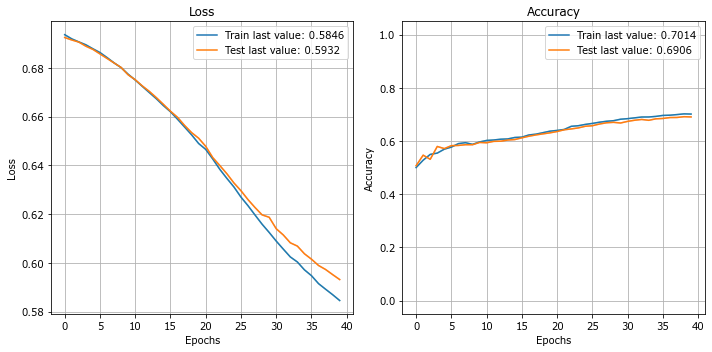

In [121]:
#Plot

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

### Adding two extra dense layers

In [122]:
# Inspect model performance with 2 hidden layers, pre-trained embeddings
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

Input = Input(shape=(None,), dtype="int32")
Embedding = embeddingLayer(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Hidden_2 = Dense(8,activation='sigmoid')(Hidden_1)          # first extra hidden layer
Hidden_3 = Dense(4,activation='sigmoid')(Hidden_2)          # second extra hidden layer
Output = Dense(1, activation='sigmoid')(Hidden_3)
model7 = Model(inputs=[Input], outputs=[Output])  

model7.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model7.summary()


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_11  (None, 300)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5  

In [123]:
#Train model
history = model7.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
#Test model
results = model7.evaluate(X_test_enc, y_test)
print (results)

Epoch 1/40
30/30 [==============================] - 3s 71ms/step - loss: 0.7712 - accuracy: 0.5007 - val_loss: 0.7459 - val_accuracy: 0.4947
Epoch 2/40
30/30 [==============================] - 2s 71ms/step - loss: 0.7326 - accuracy: 0.5061 - val_loss: 0.7226 - val_accuracy: 0.4947
Epoch 3/40
30/30 [==============================] - 2s 70ms/step - loss: 0.7138 - accuracy: 0.5059 - val_loss: 0.7092 - val_accuracy: 0.4947
Epoch 4/40
30/30 [==============================] - 2s 72ms/step - loss: 0.7043 - accuracy: 0.5039 - val_loss: 0.7020 - val_accuracy: 0.4947
Epoch 5/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6985 - accuracy: 0.5050 - val_loss: 0.6979 - val_accuracy: 0.4947
Epoch 6/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6955 - accuracy: 0.5053 - val_loss: 0.6956 - val_accuracy: 0.4947
Epoch 7/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6945 - accuracy: 0.5019 - val_loss: 0.6944 - val_accuracy: 0.4947
Epoch 8/40
30

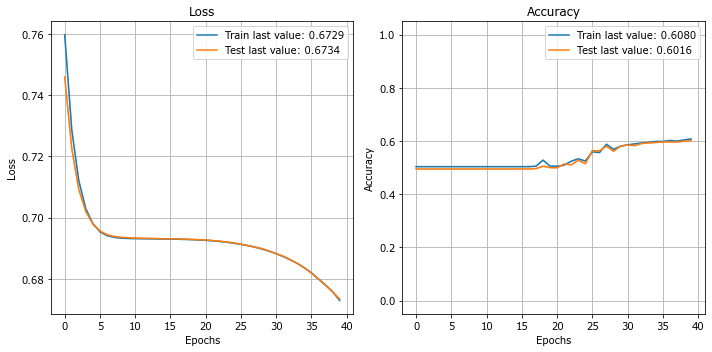

In [124]:
#Plot

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

##  Model 5-1: Basic CNN model for Text Classification 

In [125]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding, MaxPooling1D
from keras.models import Model
from keras.models import Sequential

hidden_layer=16

# your code goes here
embedding_dim = 100

#model = Sequential()
Input = Input(shape=(None,), dtype="int32")
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH, mask_zero=True)(Input)
conv1d = Conv1D(filters = 128,kernel_size= 5, activation='relu')(Embedding)
global_max_pooling1d = GlobalAveragePooling1D()(conv1d)
Hidden = Dense(10, activation='relu')(global_max_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden)
model8 = Model(inputs=[Input], outputs=[Output])
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model8.summary()


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 128)         192128    
_________________________________________________________________
global_average_pooling1d_12  (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 11        
Total params: 3,193,429
Trainable params: 3,193,429
Non-trainable params: 0
________________________________________________

In [126]:
#Train model
history = model8.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
#Test model
results = model8.evaluate(X_test_enc, y_test)
print (results)

Epoch 1/40
30/30 [==============================] - 35s 1s/step - loss: 0.6877 - accuracy: 0.5508 - val_loss: 0.6100 - val_accuracy: 0.7468
Epoch 2/40
30/30 [==============================] - 34s 1s/step - loss: 0.5205 - accuracy: 0.7997 - val_loss: 0.3380 - val_accuracy: 0.8659
Epoch 3/40
30/30 [==============================] - 34s 1s/step - loss: 0.2685 - accuracy: 0.8972 - val_loss: 0.2917 - val_accuracy: 0.8823
Epoch 4/40
30/30 [==============================] - 34s 1s/step - loss: 0.1767 - accuracy: 0.9354 - val_loss: 0.2954 - val_accuracy: 0.8842
Epoch 5/40
30/30 [==============================] - 34s 1s/step - loss: 0.1278 - accuracy: 0.9606 - val_loss: 0.3165 - val_accuracy: 0.8833
Epoch 6/40
30/30 [==============================] - 34s 1s/step - loss: 0.0922 - accuracy: 0.9751 - val_loss: 0.3560 - val_accuracy: 0.8777
Epoch 7/40
30/30 [==============================] - 34s 1s/step - loss: 0.0692 - accuracy: 0.9827 - val_loss: 0.3857 - val_accuracy: 0.8745
Epoch 8/40
30/30 [==

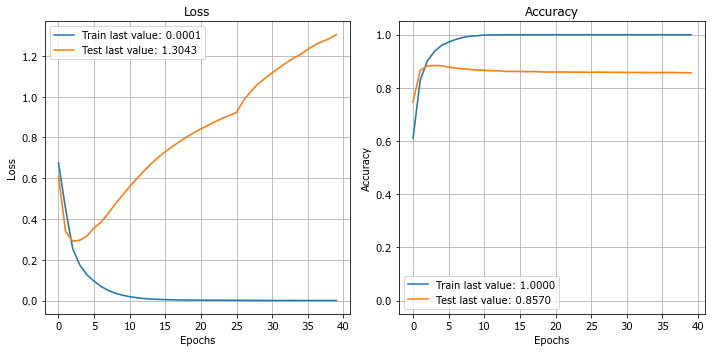

In [127]:
# your code goes here

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()


## Model 5-2: Adding extra convolutional layer

In [128]:
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding, MaxPooling1D
from keras.layers.convolutional import Conv1D 
from keras.models import Model
from keras.models import Sequential

hidden_layer=16

# your code goes here
embedding_dim = 100

#model = Sequential()
Input = Input(shape=(None,), dtype="int32")
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH, mask_zero=True)(Input)
conv1d = Conv1D(filters = 128,kernel_size= 5, activation='relu')(Embedding)
conv1d2 = Conv1D(filters = 128,kernel_size= 3, activation='relu')(conv1d)
global_max_pooling1d = MaxPooling1D()(conv1d2)
Hidden = Dense(10, activation='relu')(global_max_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden)
model9 = Model(inputs=[Input], outputs=[Output])
model9.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model9.summary()


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_12 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 128)         192128    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dense_47 (Dense)             (None, None, 10)          1290      
_________________________________________________________________
dense_48 (Dense)             (None, None, 1)           11 

In [129]:
#Train model
history = model9.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
#Test model
results = model9.evaluate(X_test_enc, y_test)
print (results)

Epoch 1/40
30/30 [==============================] - 31s 1s/step - loss: 0.6919 - accuracy: 0.5152 - val_loss: 0.6734 - val_accuracy: 0.5776
Epoch 2/40
30/30 [==============================] - 31s 1s/step - loss: 0.6579 - accuracy: 0.5967 - val_loss: 0.6436 - val_accuracy: 0.6084
Epoch 3/40
30/30 [==============================] - 35s 1s/step - loss: 0.6275 - accuracy: 0.6215 - val_loss: 0.6392 - val_accuracy: 0.6106
Epoch 4/40
30/30 [==============================] - 34s 1s/step - loss: 0.6200 - accuracy: 0.6281 - val_loss: 0.6417 - val_accuracy: 0.6029
Epoch 5/40
30/30 [==============================] - 35s 1s/step - loss: 0.6155 - accuracy: 0.6257 - val_loss: 0.6437 - val_accuracy: 0.6037
Epoch 6/40
30/30 [==============================] - 33s 1s/step - loss: 0.6103 - accuracy: 0.6342 - val_loss: 0.6426 - val_accuracy: 0.6051
Epoch 7/40
30/30 [==============================] - 32s 1s/step - loss: 0.6023 - accuracy: 0.6423 - val_loss: 0.6419 - val_accuracy: 0.6129
Epoch 8/40
30/30 [==

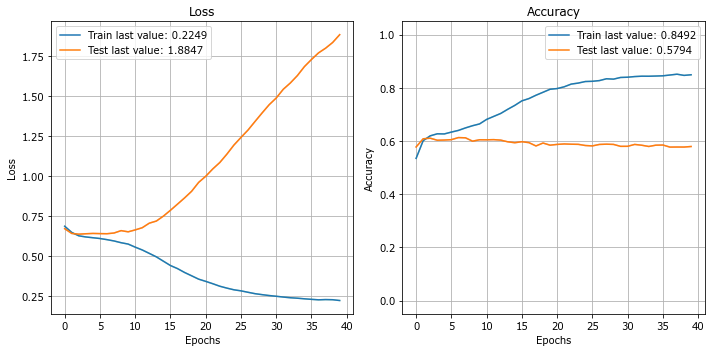

In [130]:
# your code goes here
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

plt.show()



---

